In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [20]:
DATA_PATH = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

print("\n1. DATASET STRUCTURE ANALYSIS")
print("-" * 40)

for root, dirs, files in os.walk(DATA_PATH):
    level = root[len(DATA_PATH):].count(os.sep)
    indent = '  ' * level
    print(f"{indent}{os.path.basename(root)}/")
    
    if files:
        subindent = '  ' * (level + 1)
        print(f"{subindent}{len(files)} files")


1. DATASET STRUCTURE ANALYSIS
----------------------------------------
COVID-19_Radiography_Dataset/
  5 files
  Normal/
    images/
      10192 files
    masks/
      10192 files
  Lung_Opacity/
    images/
      6012 files
    masks/
      6012 files
  Viral Pneumonia/
    images/
      1345 files
    masks/
      1345 files
  COVID/
    images/
      3616 files
    masks/
      3616 files


In [22]:
print("\n2. CLASS DISTRIBUTION ANALYSIS")
print("-" * 40)

class_folders = [f for f in os.listdir(DATA_PATH) 
                if os.path.isdir(os.path.join(DATA_PATH, f))]
print(f"Classes: {class_folders}")

# Number of Images in each class
class_counts = {}
total_images = 0

for class_name in class_folders:
    class_path = os.path.join(DATA_PATH, class_name, 'images')
    if os.path.exists(class_path):
        count = len([f for f in os.listdir(class_path) 
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = count
        total_images += count

print(f"\nTotal images: {total_images}")

class_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
class_df['Percentage'] = (class_df['Count'] / total_images) * 100

print("\nClass Distribution Summary:")
print(class_df.to_string(index=False))


2. CLASS DISTRIBUTION ANALYSIS
----------------------------------------
Classes: ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']

Total images: 21165

Class Distribution Summary:
          Class  Count  Percentage
         Normal  10192   48.154973
   Lung_Opacity   6012   28.405386
Viral Pneumonia   1345    6.354831
          COVID   3616   17.084810



3. CLASS DISTRIBUTION VISUALIZATION
----------------------------------------


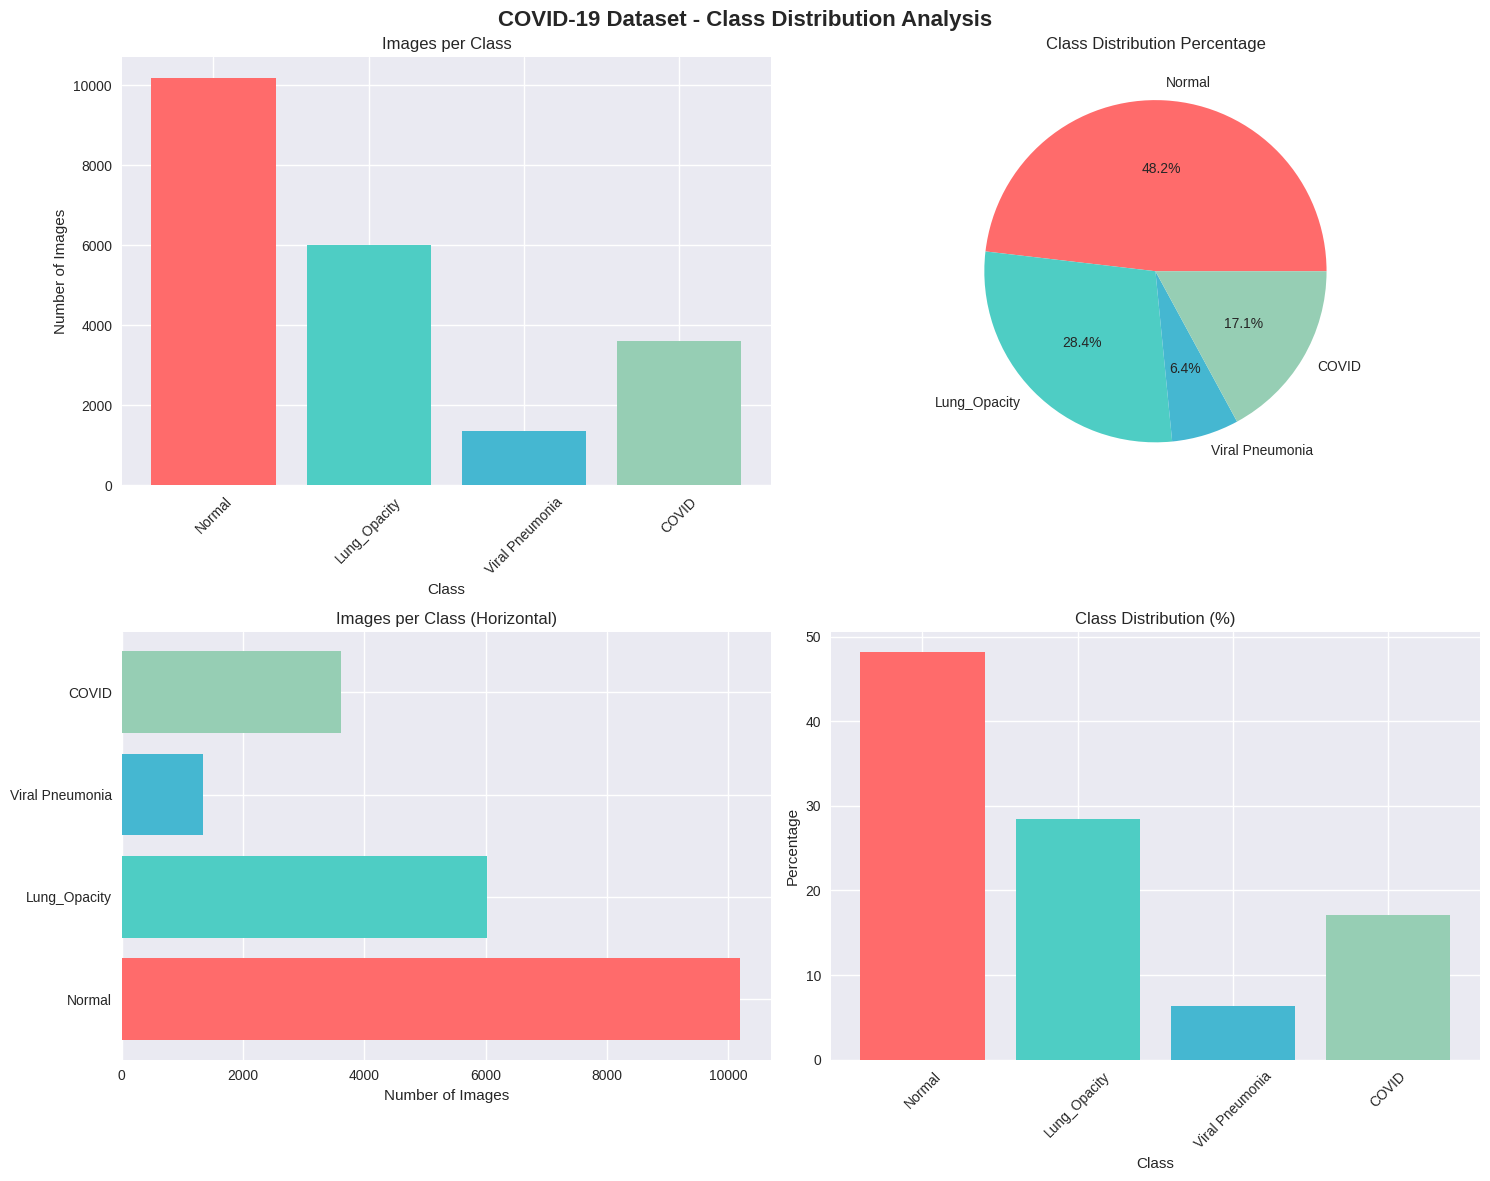

In [6]:
print("\n3. CLASS DISTRIBUTION VISUALIZATION")
print("-" * 40)

# Create subplots for class distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('COVID-19 Dataset - Class Distribution Analysis', fontsize=16, fontweight='bold')

# Bar plot
axes[0,0].bar(class_df['Class'], class_df['Count'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0,0].set_title('Images per Class')
axes[0,0].set_xlabel('Class')
axes[0,0].set_ylabel('Number of Images')
axes[0,0].tick_params(axis='x', rotation=45)

axes[0,1].pie(class_df['Count'], labels=class_df['Class'], autopct='%1.1f%%', colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0,1].set_title('Class Distribution Percentage')

# Horizontal bar plot
axes[1,0].barh(class_df['Class'], class_df['Count'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[1,0].set_title('Images per Class (Horizontal)')
axes[1,0].set_xlabel('Number of Images')

# Percentage bar plot
axes[1,1].bar(class_df['Class'], class_df['Percentage'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[1,1].set_title('Class Distribution (%)')
axes[1,1].set_xlabel('Class')
axes[1,1].set_ylabel('Percentage')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


4. SAMPLE IMAGES
----------------------------------------


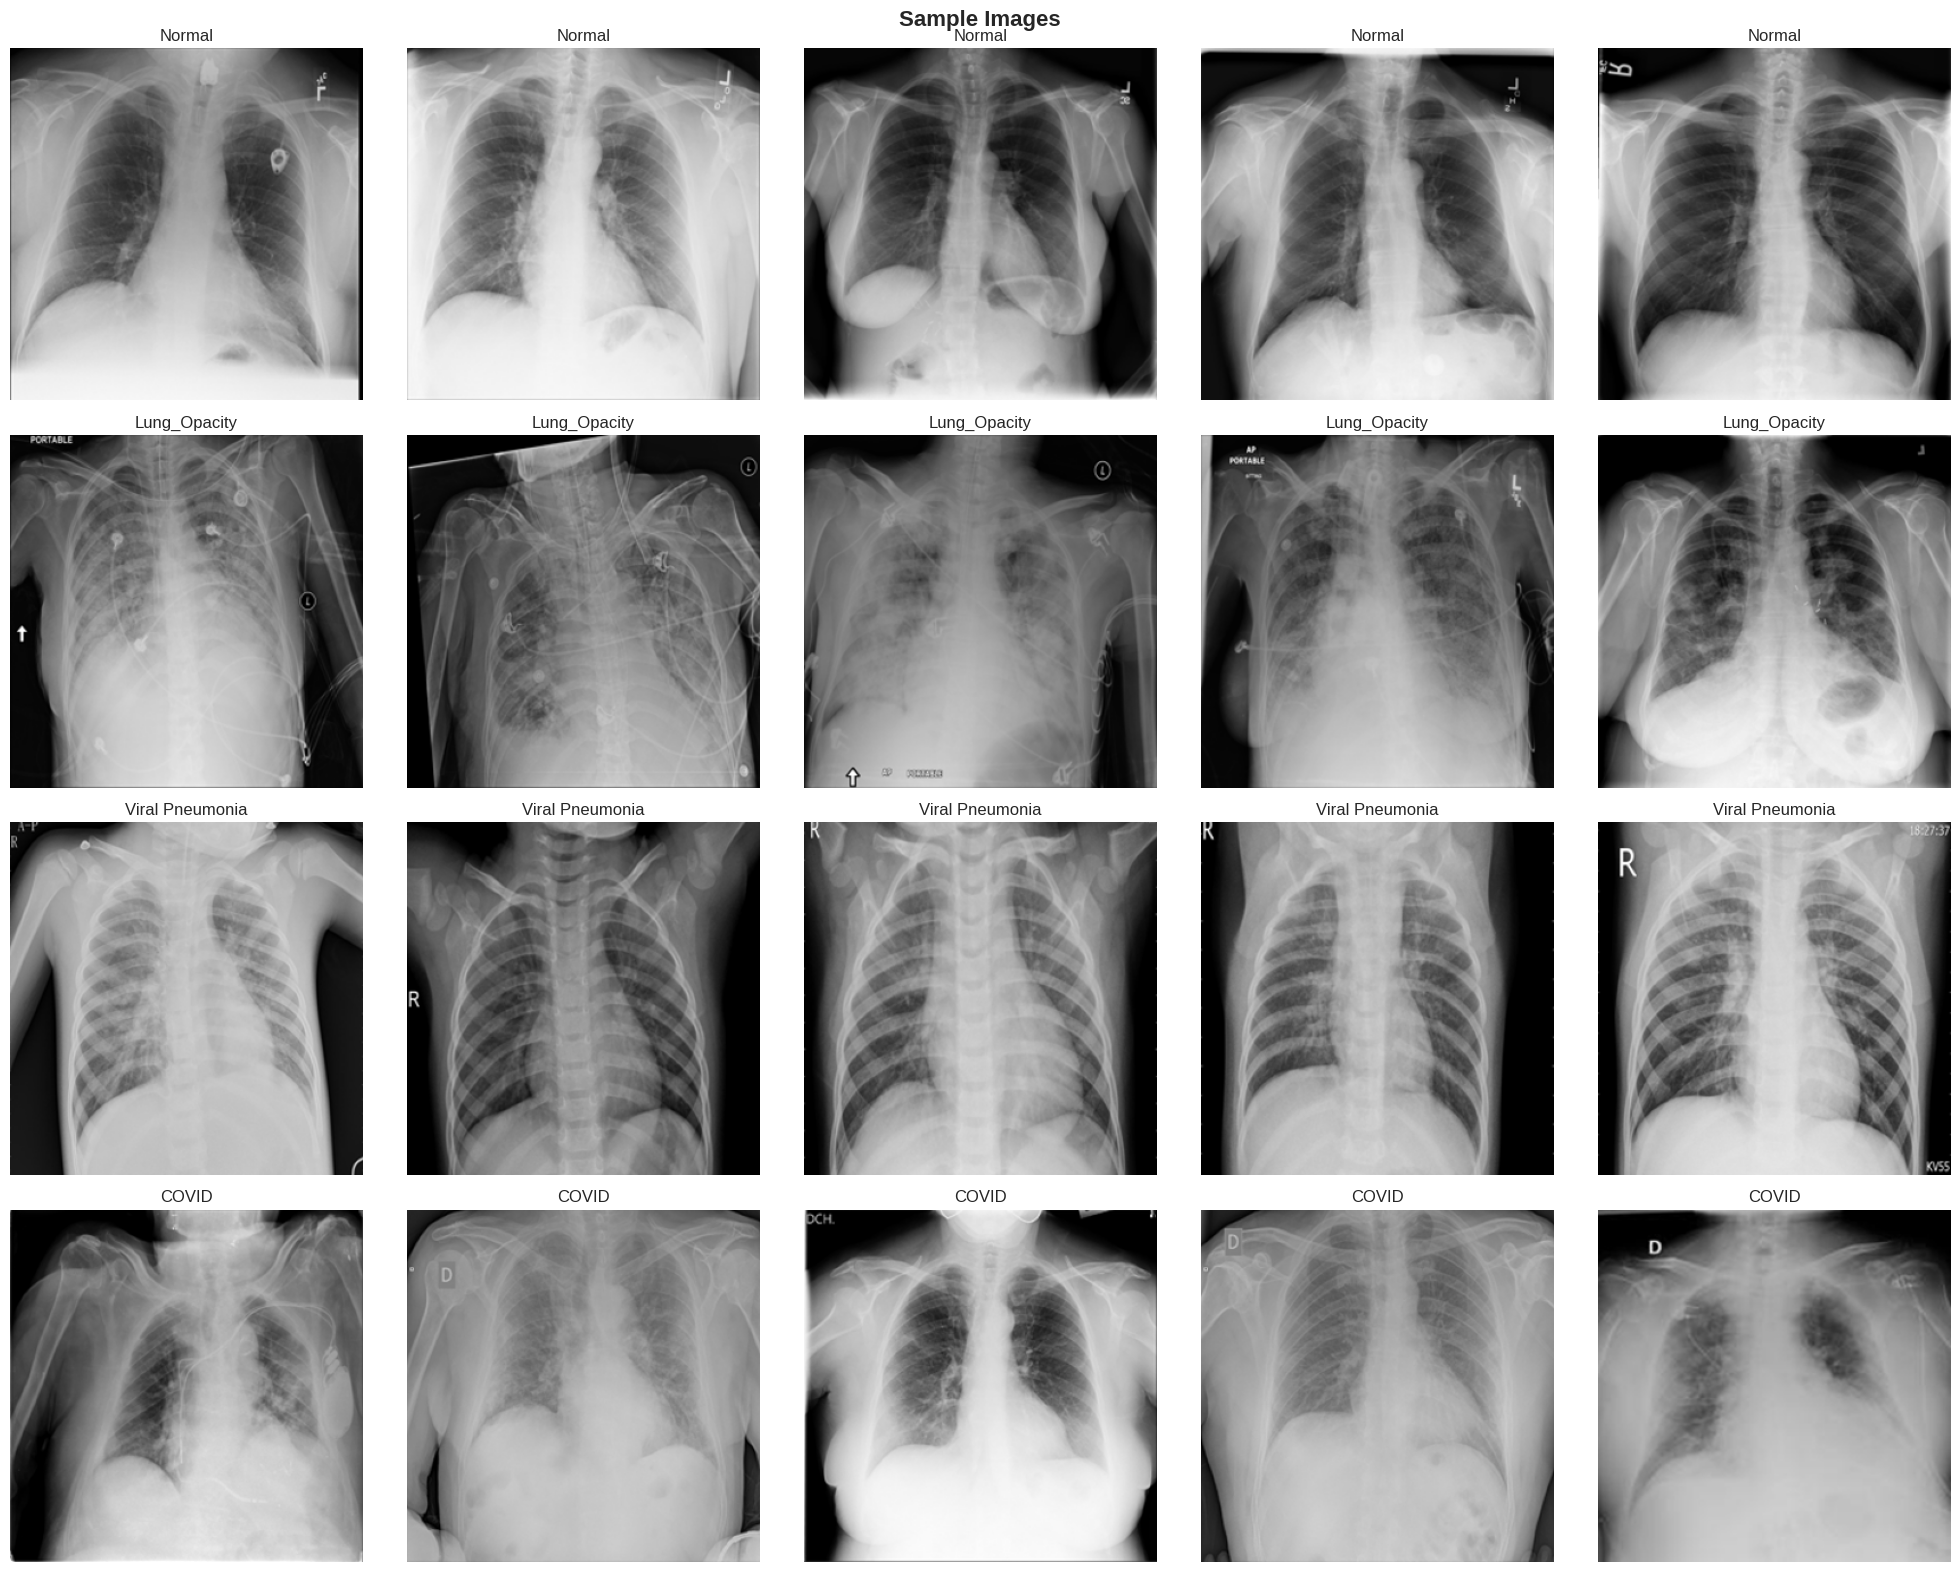

In [25]:
print("\n4. SAMPLE IMAGES")
print("-" * 40)

def load_images(class_name, num_samples=5):
    class_path = os.path.join(DATA_PATH, class_name, 'images')
    if not os.path.exists(class_path):
        return None
    
    image_files = [f for f in os.listdir(class_path) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(image_files) < num_samples:
        num_samples = len(image_files)
    
    sample_files = np.random.choice(image_files, num_samples, replace=False)
    images = []
    
    for file in sample_files:
        img_path = os.path.join(class_path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    
    return images

fig, axes = plt.subplots(len(class_folders), 5, figsize=(20, 4*len(class_folders)))
fig.suptitle('Sample Images', fontsize=16, fontweight='bold')

for i, class_name in enumerate(class_folders):
    images = load_images(class_name, 5)
    
    if images:
        for j, img in enumerate(images):
            if len(class_folders) == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            
            ax.imshow(img)
            ax.set_title(f'{class_name}')
            ax.axis('off')

plt.tight_layout()
plt.show()

In [27]:
print("\n5. IMAGE PROPERTIES ANALYSIS")
print("-" * 40)

def analyze_image_prop(class_name, num_samples=100):
    class_path = os.path.join(DATA_PATH, class_name, 'images')
    if not os.path.exists(class_path):
        return None
    
    image_files = [f for f in os.listdir(class_path) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    size = min(num_samples, len(image_files))
    files = np.random.choice(image_files, size, replace=False)
    
    properties = {
        'widths': [],
        'heights': [],
        'channels': [],
        'file_sizes': [],
        'mean_intensities': [],
        'std_intensities': []
    }
    
    for file in files:
        img_path = os.path.join(class_path, file)
        
        file_size = os.path.getsize(img_path) / 1024  # KB
        properties['file_sizes'].append(file_size)
        
        img = cv2.imread(img_path)
        if img is not None:
            h, w, c = img.shape
            properties['heights'].append(h)
            properties['widths'].append(w)
            properties['channels'].append(c)
            
            #grayscale for intensity analysis
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            properties['mean_intensities'].append(np.mean(gray))
            properties['std_intensities'].append(np.std(gray))
    
    return properties

properties_data = {}
for class_name in class_folders:
    properties = analyze_image_prop(class_name)
    if properties:
        properties_data[class_name] = properties


summary_stats = []
for class_name, props in properties_data.items():
    stats = {
        'Class': class_name,
        'Avg Width': np.mean(props['widths']),
        'Avg Height': np.mean(props['heights']),
        'Avg File Size (KB)': np.mean(props['file_sizes']),
        'Avg Intensity': np.mean(props['mean_intensities']),
        'Avg Std Intensity': np.mean(props['std_intensities'])
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print(summary_df.round(2).to_string(index=False))


5. IMAGE PROPERTIES ANALYSIS
----------------------------------------
          Class  Avg Width  Avg Height  Avg File Size (KB)  Avg Intensity  Avg Std Intensity
         Normal      299.0       299.0               37.20         130.28              60.43
   Lung_Opacity      299.0       299.0               34.60         126.26              56.75
Viral Pneumonia      299.0       299.0               40.79         123.62              57.39
          COVID      299.0       299.0               35.44         139.92              51.50


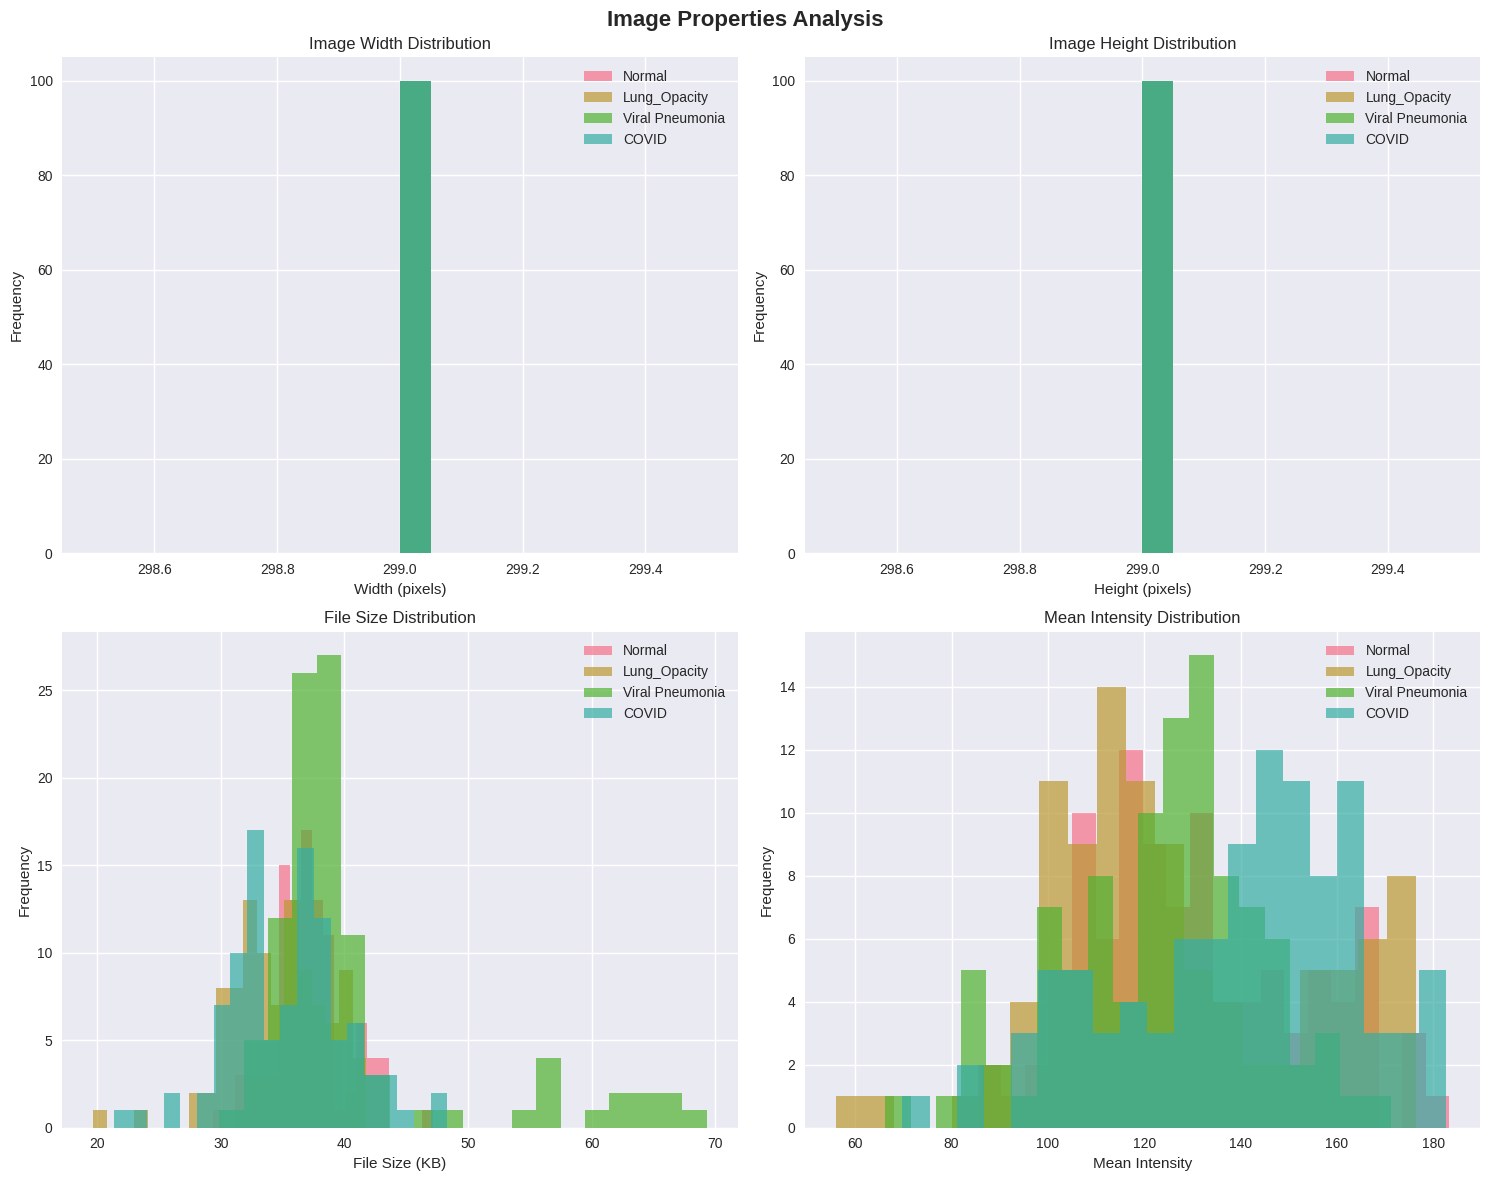

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Image Properties Analysis', fontsize=16, fontweight='bold')

# Width distribution
for class_name, props in properties_data.items():
    axes[0,0].hist(props['widths'], alpha=0.7, label=class_name, bins=20)
axes[0,0].set_title('Image Width Distribution')
axes[0,0].set_xlabel('Width (pixels)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# Height distribution
for class_name, props in properties_data.items():
    axes[0,1].hist(props['heights'], alpha=0.7, label=class_name, bins=20)
axes[0,1].set_title('Image Height Distribution')
axes[0,1].set_xlabel('Height (pixels)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# File size distribution
for class_name, props in properties_data.items():
    axes[1,0].hist(props['file_sizes'], alpha=0.7, label=class_name, bins=20)
axes[1,0].set_title('File Size Distribution')
axes[1,0].set_xlabel('File Size (KB)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# Intensity distribution
for class_name, props in properties_data.items():
    axes[1,1].hist(props['mean_intensities'], alpha=0.7, label=class_name, bins=20)
axes[1,1].set_title('Mean Intensity Distribution')
axes[1,1].set_xlabel('Mean Intensity')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [29]:
corrupted_count = 0

for class_name in class_folders:
    image_dir = os.path.join(DATA_PATH, class_name, 'images')
    if not os.path.isdir(image_dir):
        continue

    image_files = [f for f in os.listdir(image_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:50]

    for file in image_files:
        path = os.path.join(image_dir, file)
        try:
            img = cv2.imread(path)
            if img is None:
                corrupted_count += 1
        except Exception:
            corrupted_count += 1

print(f"Corrupted Images: {corrupted_count}")

Corrupted Images: 0


In [31]:
print("\n8. CLASS BALANCE ANALYSIS")
print("-" * 40)

max_count = max(class_counts.values())
min_count = min(class_counts.values())
imbalance_ratio = max_count / min_count

print(f"Maxi class size: {max_count} and Minimum class size: {min_count}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 2:
    print("Dataset is imbalanced.")
else:
    print("Dataset is balanced.")


8. CLASS BALANCE ANALYSIS
----------------------------------------
Maxi class size: 10192 and Minimum class size: 1345
Imbalance ratio: 7.58
Dataset is imbalanced.
